In [1]:
# from Pipeline import BLEPipeline, WifiPipeline
from MulticlassDCP import BLEMulticlassDCP, WifiMulticlassDCP

# General data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# ML libraries
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# System libraries
import itertools
import random, time

# Warning filtering
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# Wi-Fi Tuning

In [4]:
start_time = time.time()

In [5]:
w = WifiMulticlassDCP()

In [6]:
df = w.make_dataframe()

# Take out packets from router
df = df[df["DeviceType"]!="router"]

Router     101880
Mini        75782
Dropcam     45912
Kasa        17156
Netcam2      3056
Netcam3      2961
Netcam1      2314
Switch2      2204
Switch1      1963
Switch3      1955
Insight      1738
Switch4      1504
Lifx2         545
Lifx1         495
TpPlug        366
TpBulb        191
Name: Name, dtype: int64


In [7]:
# Divide training and test sets
df_train = df[df['Set']=='train']
df_test = df[df['Set']=='test']

In [23]:
# Wifi: Define which features to use
features_list = [
        # Packet info
        "PacketLength",
        
        # Vendor 
         "Belkin", "Dropcam", "Lifi", "Netgear", "Tp-link",
    
        # 802.11 Data subtype
        "Data", "QoS_Data", "QoS_Null",

        # Associated Packets
        "Assoc_Packets"]

# Define what the response classes are
y_list = ["bulb", "camera", "plug"]

In [9]:
# Define grid values
knn_param_grid = dict(n_neighbors=np.arange(1,15,2))
rf_param_grid = dict(max_features=np.linspace(2, len(features_list), num=5, dtype=int))
lda_param_grid = dict(n_components=np.arange(1,5))

# Time wifi gridsearch
wifi_start = time.time()

# Run gridsearch
w_knn = w.tune_gridsearch(KNeighborsClassifier(), knn_param_grid, df_train, 
                        features_list, y_list)
w_rf = w.tune_gridsearch(RandomForestClassifier(), rf_param_grid, df_train, 
                       features_list, y_list)
w_lda = w.tune_gridsearch(LinearDiscriminantAnalysis(), lda_param_grid, df_train, 
                        features_list, y_list)

wifi_end = time.time() - wifi_start

In [10]:
print wifi_end, "sec"

8595.54918885 sec


In [11]:
print w_knn['grid_result'].best_score_, w_knn['grid_result'].best_params_
print w_lda['grid_result'].best_score_, w_lda['grid_result'].best_params_
print w_rf['grid_result'].best_score_, w_rf['grid_result'].best_params_

0.9608539875702647 {'n_neighbors': 11}
0.8721724648334492 {'n_components': 1}
0.9753719005660249 {'max_features': 2}


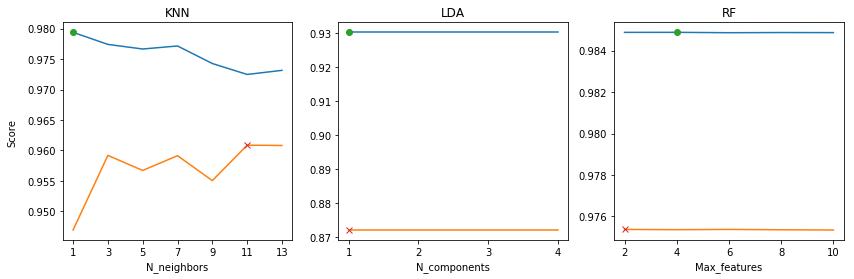

In [12]:
w.plot_all_vcs([w_knn, w_lda, w_rf])

In [24]:
knn_param_grid_extended = dict(n_neighbors=np.arange(9,21,2))
w_knn_extended = w.tune_gridsearch(KNeighborsClassifier(), knn_param_grid_extended, df_train, 
                        features_list, y_list)

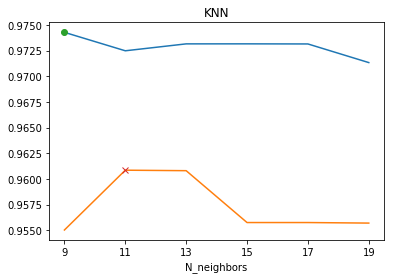

In [25]:
w.plot_vc(w_knn_extended, 'knn')

# BLE Tuning

In [13]:
b = BLEMulticlassDCP()

In [14]:
bdf = b.make_dataframe()

August2    210644
Home1       54902
Home2       54516
Push        30661
Kevo        19430
August1     15047
Weather      8101
Room2        7698
Room1        7239
Door1        6696
Door2        3587
Name: Name, dtype: int64


In [15]:
# Divide training and test sets
bdf_train = bdf[bdf['Set']=='train']
bdf_test = bdf[bdf['Set']=='test']

In [16]:
# BLE: Define which features to use
features_list = [
    # Packet info
    "PacketLength", "BLE_LL_Length",
    
    # Associate Packets
    "Assoc_Packets",
    
    # Channel number
    "Channel_0", "Channel_12", "Channel_39",
    
    # PDU Type
    "SCAN_RSP", "ADV_IND", "SCAN_REQ", 
    "CONNECT_REQ", "ADV_NONCONN_IND", "ADV_DIRECT_IND"]

y_list = ["door", "lock", "temp"]

In [17]:
# Define grid values
knn_param_grid = dict(n_neighbors=np.arange(1,15,2))
rf_param_grid = dict(max_features=np.linspace(2, len(features_list), num=5, dtype=int))
lda_param_grid = dict(n_components=np.arange(1,5))

# Time BLE gridsearch
ble_start = time.time()

# Run gridsearch
b_knn = b.tune_gridsearch(KNeighborsClassifier(), knn_param_grid, bdf_train, 
                        features_list, y_list)
b_rf = b.tune_gridsearch(RandomForestClassifier(), rf_param_grid, bdf_train, 
                       features_list, y_list)
b_lda = b.tune_gridsearch(LinearDiscriminantAnalysis(), lda_param_grid, bdf_train, 
                        features_list, y_list)

ble_end = ble_start - time.time()

In [18]:
print ble_end

-5787.23280811


In [19]:
print b_knn['grid_result'].best_score_, b_knn['grid_result'].best_params_
print b_lda['grid_result'].best_score_, b_lda['grid_result'].best_params_
print b_rf['grid_result'].best_score_, b_rf['grid_result'].best_params_

0.959570932808903 {'n_neighbors': 5}
0.509824200780175 {'n_components': 1}
0.9613673668553248 {'max_features': 7}


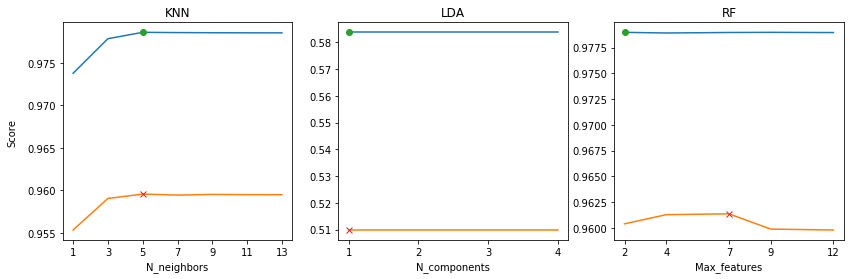

In [20]:
b.plot_all_vcs([b_knn, b_lda, b_rf])

In [21]:
end_time =  time.time() - start_time
total_gridsearch_time = ble_end + wifi_end 
print total_gridsearch_time, "sec"
print end_time, "sec"

2808.31638074 sec
